### Info
- Title: F1 Analysis
- Team: Accelerated Analytics
 
- Name: Siddharth Mehta

#### Research Questions
- Does the driver or car have more effect on race and championship position?
- How is car/driver performance affected by circumstantial factors? (weather, tyres, practice timings, circuit geography, previous race results, speed, driver measurements/experience, team funding, race laps, pit performance, time of day, type of circuit, etc) 

#### Data Source(s)
We will be using a prebuilt F1 data library called Fast F1: https://theoehrly.github.io/Fast-F1/.
This library includes F1 data updated to one year ago (2021), that being lap timing, car telemetry and position, tyre data, weather data, the event schedule and session results. If necessary, we will get geographical/geospatial circuit data from Open Elevation: https://open-elevation.com/.

## Question: Does telemetry or weather have a larger effect on speed at any given moment?

In [145]:
import fastf1 as ff1
import fastf1.plotting as f1plot

from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-whitegrid')
from matplotlib.pyplot import figure
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import pandas as pd
import numpy as np
import scipy.stats as st
import statsmodels.api as sm

from sklearn.model_selection import train_test_split as tts
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error, r2_score
#import tensorflow_decision_forests as tfdf

from datetime import datetime as dt
from dateutil.relativedelta import relativedelta

ff1.Cache.enable_cache('/Users/siddharth/Downloads/School Stuff/CMDA_3654/Project/F1-Cache')  

<ipython-input-145-d26a23dc8337>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


For this preliminary analysis, I used only Sergio Perez telemetry and weather data for the first five races of 2021. For further analysis in Part 3, I will be using all drivers over the last 10 years.

In [122]:
finaldfs = []
for i in range(1,6):
    session = ff1.get_session(2021, i, 'R')
    session.load()
    per = session.laps.pick_driver('PER')
    
    perbase = session.laps.pick_driver('PER')[['Time','LapNumber','Compound','TyreLife']]
    perbase['SessionTimeSeconds'] = [st.seconds for st in perbase.Time]
    perbase.rename(columns={'Time':'SessionTime'}, inplace=True)

    pertel = per.pick_accurate().get_telemetry()
    pertel = pertel.where(pertel['Speed'] > 0.0).dropna()

    pertelcar = pd.merge(per.pick_accurate().get_car_data(), pertel, on='SessionTime', how='inner')
    for col in pertelcar.columns:
        if col[-1:]=='y':
            pertelcar.drop(col, axis=1, inplace=True)
    perweath = per.pick_accurate().get_weather_data()
    perweath.rename(columns={'Time':'SessionTime'}, inplace=True)

    pertelcar['SessionTimeSeconds'] = [st.seconds for st in pertelcar.SessionTime]
    perweath['SessionTimeSeconds'] = [st.seconds for st in perweath.SessionTime]

    final = pd.merge(pertelcar, perbase, on='SessionTimeSeconds', how='outer').fillna(method='ffill').dropna()
    final = pd.merge(final, perweath, on='SessionTimeSeconds', how='outer').fillna(method='ffill').dropna()

    final['Compound'] = [1 if c=='SOFT' else 2 if c=='MEDIUM' else 3 for c in final.Compound]
    final['DriverAhead'] = [1 if d!='' else 0 for d in final.DriverAhead]
    final['Brake_x'] = [1 if b==True else 0 for b in final.Brake_x]
    final['Rainfall'] = [1 if r==True else 0 for r in final.Rainfall]
    final = final[['Speed_x', 'RPM_x', 'DRS_x', 'DriverAhead', 'DistanceToDriverAhead', 'LapNumber',
                   'Compound', 'TyreLife','X', 'Y', 'Z', 'AirTemp', 'Humidity', 'Pressure', 'Rainfall', 
                   'TrackTemp', 'WindDirection', 'WindSpeed']]
    finaldfs.append(final)
    
final = pd.concat([df for df in finaldfs])
'''
final_copy = final.copy()
final_copy.index = [str(s) for s in final_copy.Speed_x]
final_copy.drop('Speed_x', axis=1, inplace=True)
quant = final_copy.iloc[:,2:]
norm = (quant - quant.mean())/quant.std()
'''
final

core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '4', '11', '16', '3', '55', '22', '18', '7', '99', '31', '63', '5', '47', '10', '6', '14', '9']
core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timin

,Speed_x,RPM_x,DRS_x,DriverAhead,DistanceToDriverAhead,LapNumber,Compound,TyreLife,X,Y,Z,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
191,116.0,9991.0,0.0,1,4.098889,5.0,3,3.0,2300.0,6556.0,-135.0,20.5,54.0,1014.8,0,28.0,11.0,1.2
192,108.0,9258.0,0.0,1,4.632222,5.0,3,3.0,2238.0,6589.0,-137.0,20.5,54.0,1014.8,0,28.0,11.0,1.2
193,98.0,8299.0,0.0,1,5.298889,5.0,3,3.0,2179.0,6611.0,-136.0,20.5,54.0,1014.8,0,28.0,11.0,1.2
194,92.0,7860.0,0.0,1,2.296944,5.0,3,3.0,2124.0,6621.0,-138.0,20.5,54.0,1014.8,0,28.0,11.0,1.2
195,84.0,7359.0,0.0,1,6.496944,5.0,3,3.0,2073.0,6618.0,-138.0,20.5,54.0,1014.8,0,28.0,11.0,1.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24364,250.0,11362.0,0.0,1,137.324722,77.0,3,42.0,-7581.0,-7423.0,502.0,20.9,59.0,1015.8,0,34.0,170.0,0.5
24365,253.0,11578.0,0.0,0,137.324722,77.0,3,42.0,-7608.0,-7254.0,503.0,20.9,59.0,1015.8,0,34.0,170.0,0.5
24366,256.0,11701.0,0.0,0,137.324722,77.0,3,42.0,-7625.0,-7110.0,503.0,20.9,59.0,1015.8,0,34.0,170.0,0.5
24367,259.0,11765.0,0.0,0,137.324722,77.0,3,42.0,-7637.0,-6971.0,502.0,20.9,59.0,1015.8,0,34.0,170.0,0.5


I decided to use a decision tree regressor to start off with, as decision trees algorithms are able to identify input factors with the most entropy at a given depth.

In [123]:
X = final[['Speed_x']]
y = final.drop('Speed_x', axis=1)
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)

In [127]:
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [129]:
pd.DataFrame(y_pred)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,10830.029240,0.309942,0.982456,364.092699,33.505848,1.900585,19.368421,-2761.038012,-1538.923977,948.207602,19.066082,56.859357,1007.591813,0.046784,30.205848,111.555556,0.638889
1,8456.112805,0.216463,0.957317,332.783917,33.628049,1.917683,20.719512,-3192.048780,-1347.314024,1033.070122,18.921037,56.022256,1008.820427,0.039634,32.311280,136.500000,0.572866
2,9393.842752,0.203931,0.975430,394.589124,32.434889,2.007371,19.737101,-1236.545455,-633.331695,1061.594595,18.698526,56.011794,1007.414496,0.066339,30.636855,110.260442,0.655774
3,10844.158602,0.551075,0.975806,426.632288,34.483871,1.973118,19.456989,-1799.774194,-740.494624,978.876344,19.060484,55.234140,1007.372043,0.040323,30.315591,106.225806,0.665054
4,11090.634033,0.617716,0.902098,470.802780,37.291375,1.822844,22.279720,-1625.053613,-1466.988345,1137.226107,18.286480,52.496503,1006.603263,0.048951,30.914452,102.365967,0.696503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21578,6869.863248,0.213675,0.961538,276.517472,37.576923,2.243590,21.923077,-1687.393162,351.098291,669.047009,19.929915,54.828632,1012.382051,0.000000,33.357692,134.850427,0.621368
21579,7460.638743,0.246073,0.981675,355.843194,35.112565,2.125654,23.251309,-1714.036649,-171.502618,808.439791,19.112827,56.717277,1010.584555,0.000000,31.903141,143.023560,0.613089
21580,10824.417874,0.437198,0.951691,418.131597,32.572464,2.004831,20.314010,-1693.012077,-537.852657,989.000000,19.430193,54.582850,1007.210145,0.031401,31.138406,104.019324,0.673913
21581,10917.454315,0.553299,0.956853,386.012028,32.291878,1.979695,19.835025,-2101.357868,-1034.583756,1047.195431,19.059645,55.082234,1006.539340,0.048223,30.510914,99.459391,0.676650


In [130]:
np.sqrt(mean_squared_error(y_test, y_pred)), mean_absolute_error(y_test, y_pred)

(1623.4511059352658, 532.8730177457833)

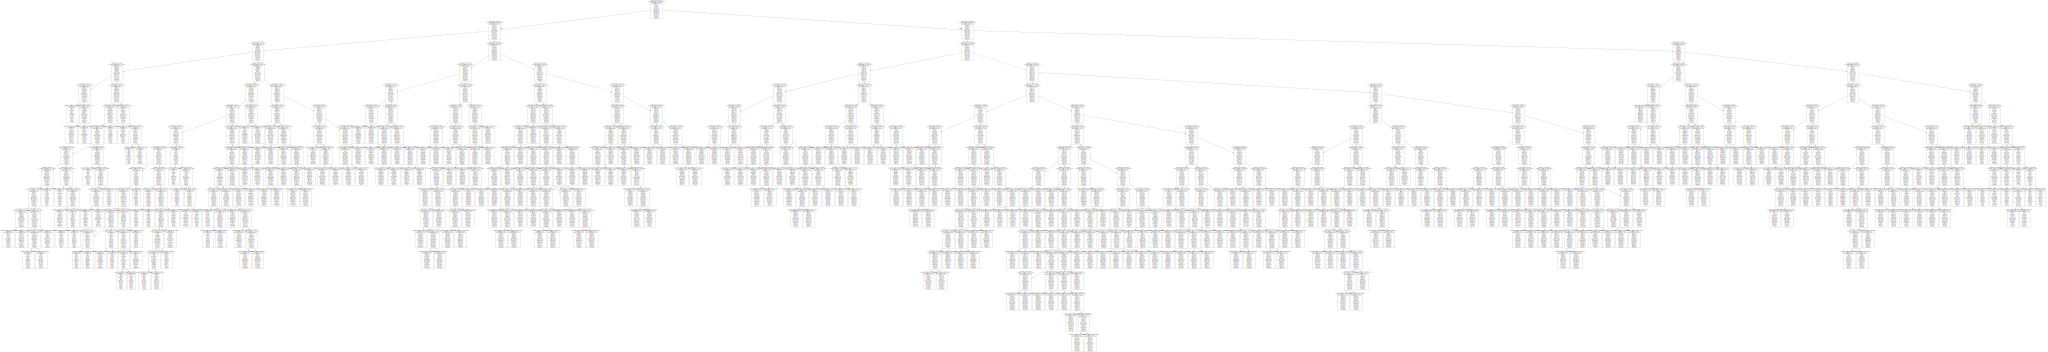

In [131]:
import graphviz
from sklearn import tree
  
# export the decision tree to a tree.dot file
# for visualizing the plot easily anywhere
dot_data = tree.export_graphviz(reg, feature_names=['Speed_x'])

graph = graphviz.Source(dot_data, format="png") 
graph

The decision tree regression needs to be trained with dimensionally reduced data. Ideally, the dimensions should capture 97% of the variance in the data. This, however, will have to be done at a different time. Instead, I moved on to a robust linear regression, which should deal with the heteroskedasticity of the residuals at large sample sizes like the one I'm working with here

In [ ]:
'''
train_df = pd.DataFrame(y_train)
train_df['Speed'] = X_train.reset_index().drop('index', axis=1).Speed_x

test_df = pd.DataFrame(y_test)
test_df['Speed'] = X_test.reset_index().drop('index', axis=1).Speed_x

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_df, label="Speed")
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label="Speed")

model = tfdf.keras.RandomForestModel()
model.fit(train_ds)
model.summary()
model.evaluate(test_ds)
'''

# Attempt was made to do the decision tree regression with TensorFlow, however, my computer OS is not up to date

None

Instead of a decision tree, I decided to use a robust linear model, which can hopefully eliminate some of the heteroskedasticity in the error term naturally present in exceptionally large datasets like the one I'm working with.

In [132]:
rlm = sm.RLM(X_train, y_train, M=sm.robust.norms.HuberT())
results = rlm.fit()
#results.predict(X_test)

In [133]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:                Speed_x   No. Observations:                86332
Model:                            RLM   Df Residuals:                    86315
Method:                          IRLS   Df Model:                           16
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 06 Nov 2022                                         
Time:                        23:27:11                                         
No. Iterations:                    14                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
RPM_x                     0.0310      0.000    296.836      0.000       0.031       0.031
DRS_x                     4.9961      0.075     66.261      0.000       4.848       5.144
DriverAhead             -13.0770      1.117    -11.709      0.000     -15.266     -10.888
DistanceToDriverAhead     0.0058      0.000     11.899      0.000       0.005       0.007
LapNumber                -0.0109      0.010     -1.093      0.274      -0.030       0.009
Compound                 -5.6838      0.240    -23.666      0.000      -6.154      -5.213
TyreLife                 -0.0820      0.017     -4.875      0.000      -0.115      -0.049
X                        -0.0003   5.59e-05     -4.991      0.000      -0.000      -0.000
Y                        -0.0008   5.41e-05    -13.909      0.000      -0.001      -0.001
Z                         0.0027      0.000      8.955      0.000       0.002       0.003
AirTemp                   1.8092      0.091     19.826      0.000       1.630       1.988
Humidity                 -1.5263      0.040    -38.008      0.000      -1.605      -1.448
Pressure                  0.0016      0.004      0.432      0.666      -0.006       0.009
Rainfall                  9.1833      0.956      9.604      0.000       7.309      11.058
TrackTemp                -2.0292      0.057    -35.557      0.000      -2.141      -1.917
WindDirection            -0.0055      0.002     -3.055      0.002      -0.009      -0.002
WindSpeed                 4.3776      0.915      4.785      0.000       2.585       6.171
=========================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

It seems like the advent of a driver ahead, as well as the tire compound and track temperature are the most detrimental to speed. On the other hand, wind speed, the use of DRS, and rainfall seem to be the most beneficial. Of the six factors that I just listed, three are telemetry and three are weather, meaning telemetry and weather seem to have an equal impact on speed.

Text(0.5, 0, 'Recording')

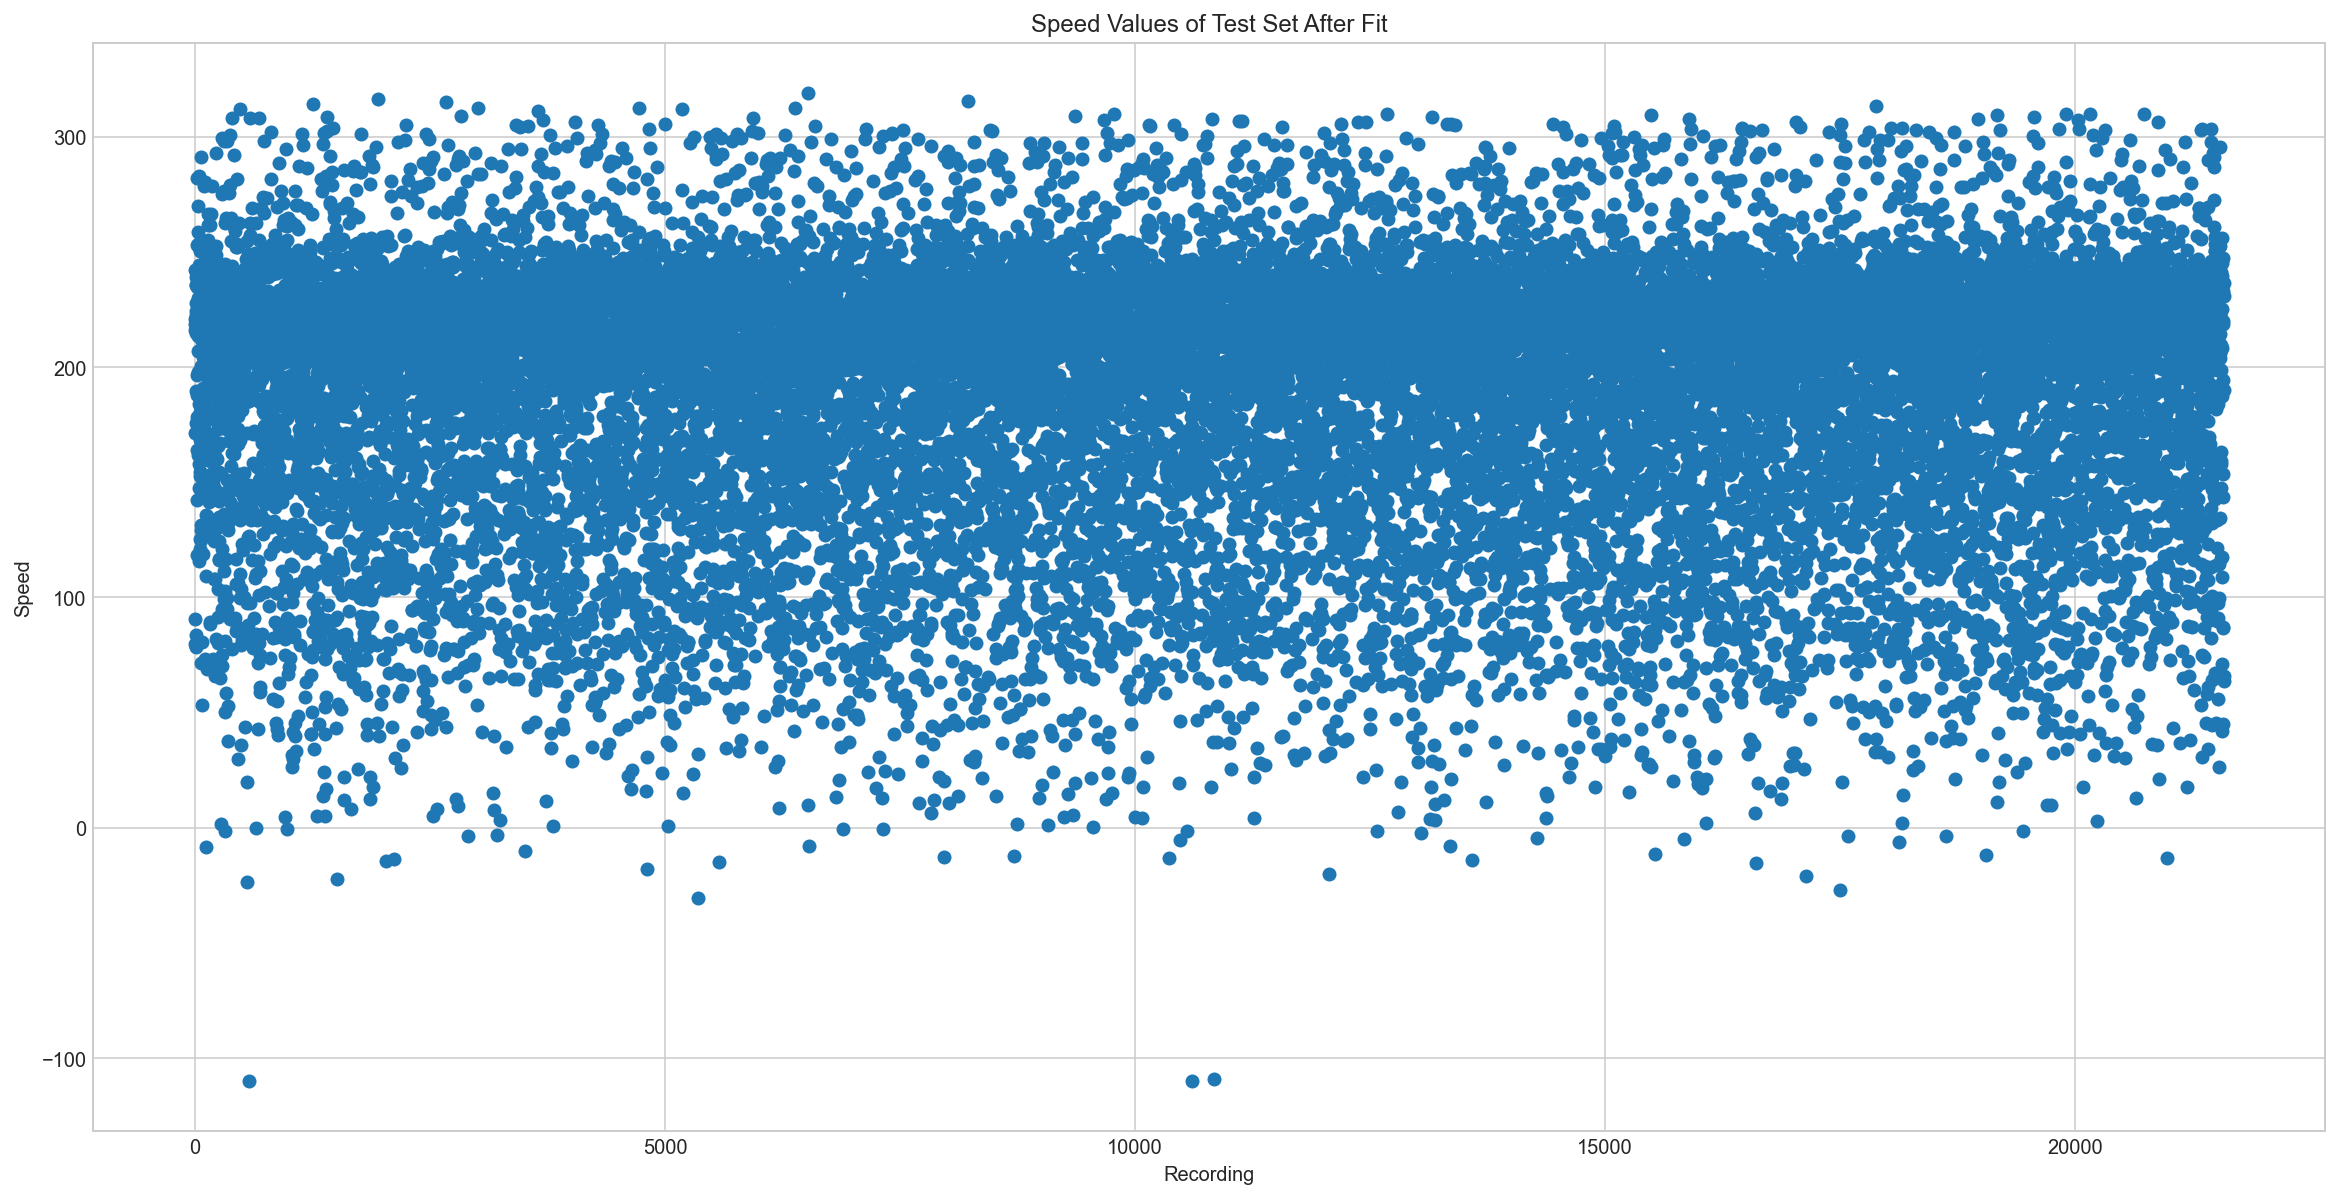

In [135]:
fig, ax = plt.subplots(figsize=(20,10))

ax.scatter(range(0,len(results.predict(y_test))), results.predict(y_test))
ax.set_title('Speed Values of Test Set After Fit')
ax.set_ylabel('Speed')
ax.set_xlabel('Recording')

Text(0.5, 0, 'Parameter')

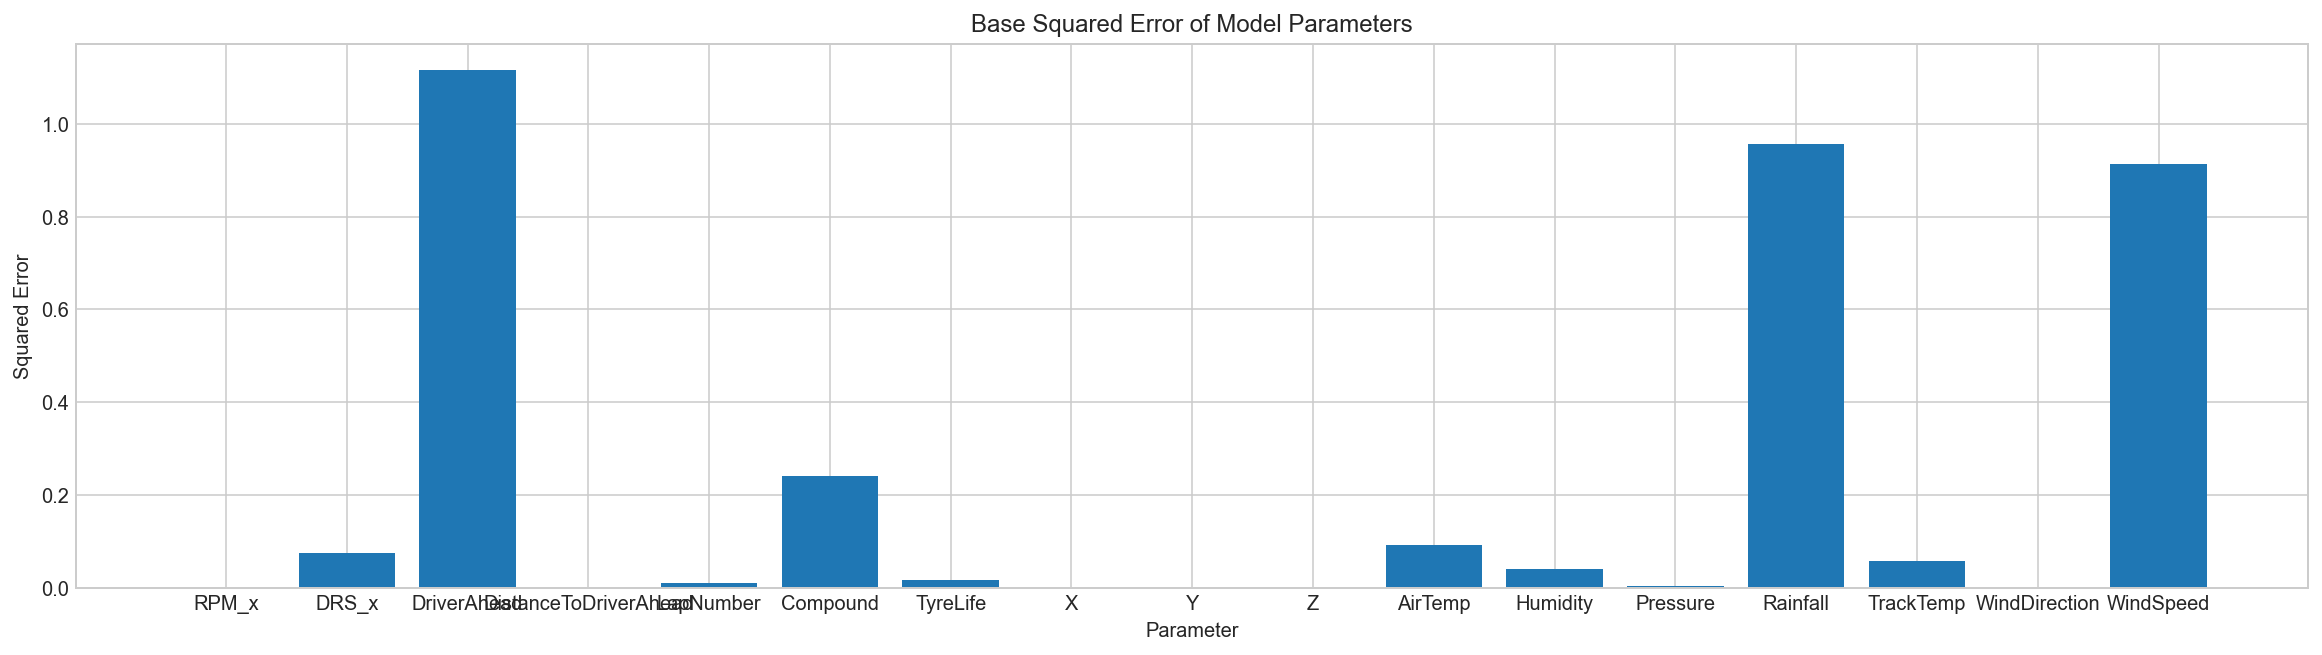

In [141]:
fig, ax = plt.subplots(figsize=(20,5))

ax.bar(results.bse.index, results.bse)
ax.set_title('Base Squared Error of Model Parameters')
ax.set_ylabel('Squared Error')
ax.set_xlabel('Parameter')

Text(0.5, 0, 'Recording')

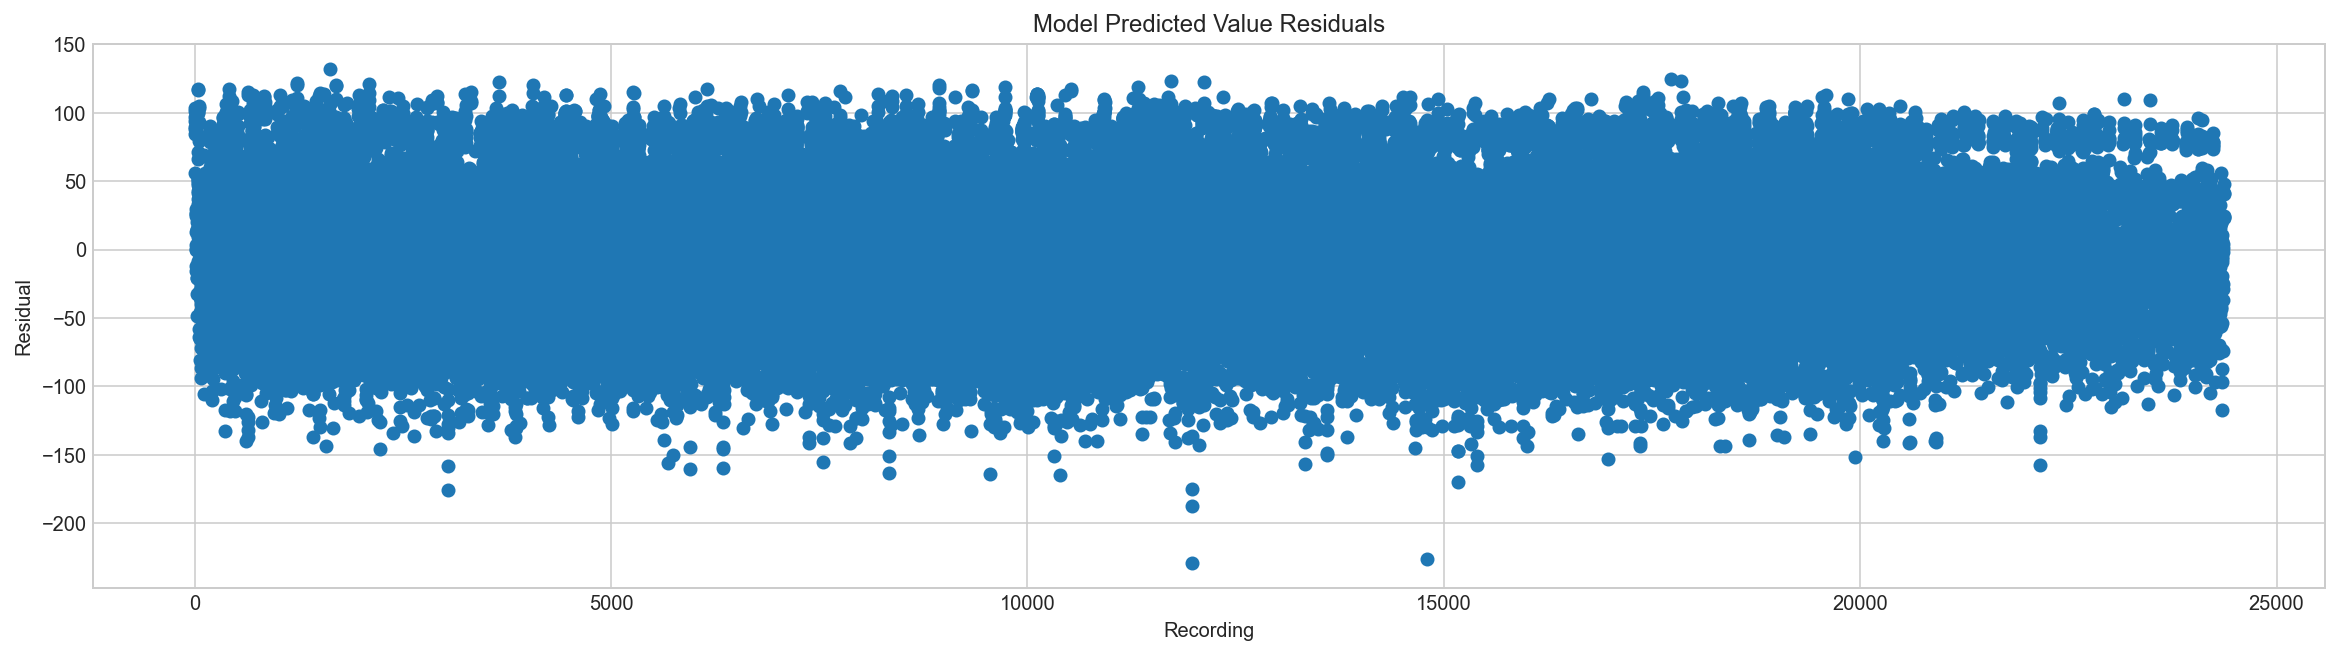

In [144]:
fig, ax = plt.subplots(figsize=(20,5))

ax.scatter(results.resid.index, results.resid)
ax.set_title('Model Predicted Value Residuals')
ax.set_ylabel('Residual')
ax.set_xlabel('Recording')